# STA365
## Homework 10

### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

**Gaussian Process (GP)** is a specific type of stochastuc process where any finite set of variables has a joint multivariate Gaussian distribution. It is entirely specified by a mean funftion and a covariance (kernel) function. They are typically used in non-paramteric Bayesian modelin for regression and classification tasks. 

**Stochastic Process** is a collection of random variables defined on a common probability space where it is indexed by time or space. It describes how a system evolves in a probabilistic manner over time, but with randomnessinvolved. (e.g, Brownian motion)

Variational Inference using the Evidence Lower Bound (ELBO)
**Variational Inference (VI)** is a method for approximating complex probability distributions, typically in Bayesian inference. Instead of sampling (like MCMC), VI turns inference into an optimization problem.
**ELBO (Evidence Lower Bound)** is the objective function in VI. It lower-bounds the log marginal likelihood (evidence) and is optimized to make the approximation close to the true posterior.

We can also formally write it down as 
$$\log p(x) \geq \mathbb{E}_{q(z)}\left[ \log \frac{p(x, z)}{q(z)} \right] 
= \mathbb{E}_{q(z)}\left[ \log p(x, z) \right] - \mathbb{E}_{q(z)}\left[ \log q(z) \right] 
= \text{ELBO}$$


Therefore, maximizing the ELBO minimizes the KL divergence between the approximate posterior $q(z)$ and the true posterior $p(z∣x)$.

---
### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(142)
X = np.linspace(0, 30, 30)[:, None]  # Days
true_temp = 10 + 10*np.sin(X[:, 0] * np.pi / 15)
y = true_temp + np.random.normal(0, 1.5, size=X.shape[0])


In [22]:
import pymc as pm

with pm.Model() as model:
    # Mean and covariance functions
    mean_func = pm.gp.mean.Constant(c=10)
    cov_func = pm.gp.cov.ExpQuad(1, ls=5.0)
    
    # GP definition
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    
    # GP likelihood
    sigma = pm.HalfNormal("sigma", 5.0)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

    # Sampling
    trace = pm.sample(1000, chains=2, progressbar=True)


/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [25]:
X_new = np.linspace(0, 30, 100)[:, None]
with model:
    f_new = gp.conditional("f_new", X_new)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_new"])
    

Sampling: [f_new]


KeyError: 'f_new'

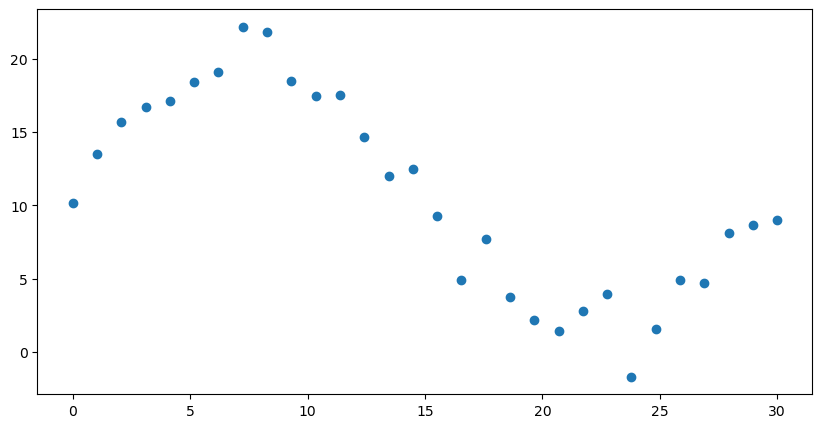

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(X, y, "o", label="Observed")
plt.plot(X_new, pred_samples["f_new"].mean(axis=0), label="Mean Prediction")
plt.fill_between(
    X_new[:, 0],
    np.percentile(pred_samples["f_new"], 5, axis=0),
    np.percentile(pred_samples["f_new"], 95, axis=0),
    alpha=0.3,
    label="90% Credible Interval"
)
plt.title("GP Regression on Daily Temperature")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend()
plt.show()


---
### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load California housing dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Standardize features
X = StandardScaler().fit_transform(X)
y = (y - y.mean()) / y.std()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [13]:
import pymc as pm
import pytensor.tensor as pt

n_hidden = 10
n_input = X_train.shape[1]

with pm.Model() as bnn_model:
    # Weights and biases for hidden layer
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(n_input, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))

    # Hidden layer activation
    h = pt.tanh(pt.dot(X_train, w1) + b1)

    # Output layer
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(n_hidden,))
    b2 = pm.Normal("b2", mu=0, sigma=1)

    mu = pt.dot(h, w2) + b2

    # Observation noise
    sigma = pm.HalfNormal("sigma", 1.0)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)


In [14]:
with bnn_model:
    approx = pm.fit(method='advi', n=20000)



Finished [100%]: Average Loss = 17,811


In [16]:
with bnn_model:
    # Sample from the variational posterior
    posterior = approx.sample(draws=1000)

    # Then sample from the posterior predictive
    posterior_predictive = pm.sample_posterior_predictive(posterior, model=bnn_model)

Sampling: [y_obs]


In [18]:
import numpy as np

w1_mean = posterior.posterior["w1"].mean(dim=["chain", "draw"]).values
b1_mean = posterior.posterior["b1"].mean(dim=["chain", "draw"]).values
w2_mean = posterior.posterior["w2"].mean(dim=["chain", "draw"]).values
b2_mean = posterior.posterior["b2"].mean(dim=["chain", "draw"]).values

import pytensor
import pytensor.tensor as pt

X_shared = pytensor.shared(X_test)

# Define test-time prediction using deterministic forward pass
h_test = pt.tanh(pt.dot(X_shared, w1_mean) + b1_mean)
y_test_pred = pt.dot(h_test, w2_mean) + b2_mean

# Compile function
predict_fn = pytensor.function([], y_test_pred)
y_pred = predict_fn()


In [19]:
n_samples = 100
y_pred_samples = []

for i in range(n_samples):
    w1_i = posterior.posterior["w1"].isel(draw=i, chain=0).values
    b1_i = posterior.posterior["b1"].isel(draw=i, chain=0).values
    w2_i = posterior.posterior["w2"].isel(draw=i, chain=0).values
    b2_i = posterior.posterior["b2"].isel(draw=i, chain=0).values

    h_i = np.tanh(X_test @ w1_i + b1_i)
    y_i = h_i @ w2_i + b2_i
    y_pred_samples.append(y_i)

y_pred_samples = np.array(y_pred_samples)

y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_std = y_pred_samples.std(axis=0)


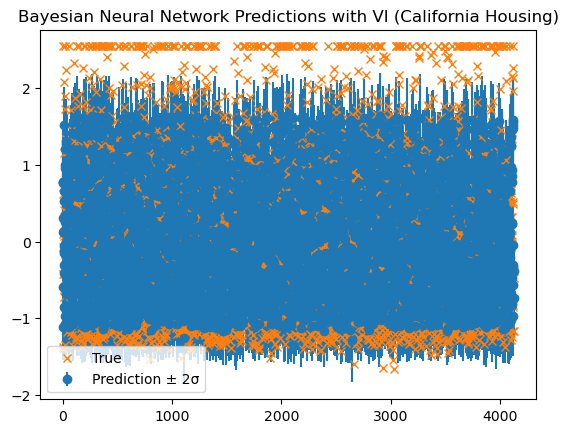

In [20]:
plt.errorbar(range(len(y_test)), y_pred_mean, yerr=2*y_pred_std, fmt='o', label='Prediction ± 2σ')
plt.plot(range(len(y_test)), y_test, 'x', label='True')
plt.legend()
plt.title("Bayesian Neural Network Predictions with VI (California Housing)")
plt.show()